In [1]:
# CODE REFERENCES
# https://towardsdatascience.com/how-to-build-an-image-classifier-for-waste-sorting-6d11d3c9c478
# https://github.com/danny95333/Trash-Classification-based-on-CNN
from linear_classifier import *
from linear_svm import *
from softmax import *
import time
import random
import shutil
import re
import os
from pathlib import Path
from PIL import Image
import numpy as np
import imghdr
import pickle
import matplotlib.pyplot as plt

In [2]:
# Declare the relative path to the PROCESSED trashnet data
# i.e. this path should go to "train", "test", "val" folders each of which 
# contain images for the train, test, and validation sets respectively.
dataRoot = "../../datasets/trashnet/data"

In [3]:
##########################
# Loading the dataset into memory and applying transforms
##########################

# TODO: Preinitialize X etc. as zeros

def load_image( infilename ) :
    '''
    Helper function to manually load in images. Accepts image path infilename 
    and returns the numpy array representation of the image data
    (Need final X to be of dims (N, H, W, D))
    '''
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

# Load the training data
arrayList = []
labelList = []
trainRoot = os.path.join(dataRoot, "train")
for c in os.listdir(os.path.join(trainRoot)):
    for item in os.listdir(os.path.join(trainRoot, c)):
        if imghdr.what(os.path.join(trainRoot, c, item)):
            # Convert the image to a numpy array
            data = load_image(os.path.join(trainRoot, c, item))
            # Add to the array which we will stack at the end to form X
            arrayList.append(data)
            # Add label to array for Y
            labelList.append(c)
X_train = np.stack(tuple(arrayList))
y_train = np.array(labelList)
        
            
# Load the validation data
arrayList = []
labelList = []
valRoot = os.path.join(dataRoot, "val")
for c in os.listdir(os.path.join(valRoot)):
    for item in os.listdir(os.path.join(valRoot, c)):
        if imghdr.what(os.path.join(valRoot, c, item)):
            # Convert the image to a numpy array
            data = load_image(os.path.join(valRoot, c, item))
            # Add to the array which we will stack at the end to form X
            arrayList.append(data)
            # Add label to array for Y
            labelList.append(c)
X_val = np.stack(tuple(arrayList))
y_val = np.array(labelList)

# Load the test data
arrayList = []
labelList = []
testRoot = os.path.join(dataRoot, "test")
for item in os.listdir(testRoot):
    if imghdr.what(os.path.join(testRoot, item)):
        # Produce label from filename
        ########
        # TODO: Go back to dataloader and change it so we bucket test data into the same 
        # subfolder structure as train and val data
        ########
        c = os.path.splitext(re.sub("[0-9]+", "", item))[0]
        data = load_image(os.path.join(testRoot, item))
        arrayList.append(data)
        labelList.append(c)
X_test = np.stack(tuple(arrayList))
y_test = np.array(labelList)


In [4]:
# Flatten X matrices down for SVM classification
imageDim = 384*512*3

X_train = X_train.reshape((X_train.shape[0], imageDim))
X_val = X_val.reshape((X_val.shape[0], imageDim))
X_test = X_test.reshape((X_test.shape[0], imageDim))

In [5]:
# Sanity check dimensions
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1549, 589824)
(1549,)
(950, 589824)
(950,)
(970, 589824)
(970,)


[205.03873467 195.42414461 188.85409942 205.09038089 195.50677857
 188.95287282 205.00322789 195.46029697 188.90316333 204.8373144 ]


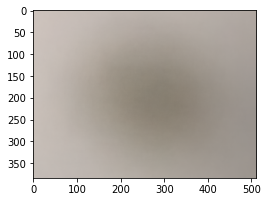

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((384,512,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train = X_train.astype(float) - mean_image
X_val = X_val.astype(float) - mean_image
X_test = X_test.astype(float) - mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape)

(1549, 589825) (950, 589825) (970, 589825)


In [9]:
# Encode the class labels
from sklearn.preprocessing import LabelEncoder
classes = ["cardboard", "compost", "glass", "metal", "paper", "plastic", "trash"]
le = LabelEncoder()
le.fit(classes)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [10]:
# TRAIN THE MODEL
svm = LinearSVM()
tic = time.time()
print("Training model with {} rows of training data".format(X_train.shape[0]))
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('Training Complete. That took %fs' % (toc - tic))

Training model with 1549 rows of training data
iteration 0 / 1500: loss 51718.898037
iteration 100 / 1500: loss 18946.915099
iteration 200 / 1500: loss 6951.280517
iteration 300 / 1500: loss 2553.563337
iteration 400 / 1500: loss 939.238558
iteration 500 / 1500: loss 345.048663
iteration 600 / 1500: loss 129.660675
iteration 700 / 1500: loss 52.580521
iteration 800 / 1500: loss 20.398072
iteration 900 / 1500: loss 11.939894
iteration 1000 / 1500: loss 7.965136
iteration 1100 / 1500: loss 4.260402
iteration 1200 / 1500: loss 3.919535
iteration 1300 / 1500: loss 6.103146
iteration 1400 / 1500: loss 3.840542
Training Complete. That took 1675.165843s


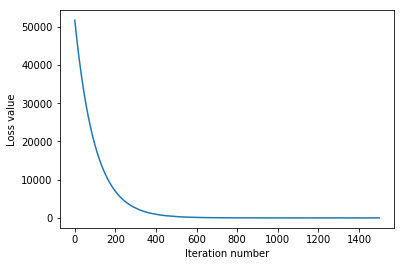

In [17]:
# Plot the loss as a function iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
########################################
# Pickle / Unpickle model
########################################

In [13]:
# Serialize and persist the trained model
# outName = "baseline_trained.p"
# pickle.dump(svm, open(outName, "wb"))

In [11]:
# TEST: Verify that we can reload the serialized trained model data
svm = pickle.load(open("baseline_trained.p", "rb"))

In [ ]:
########################################
# Accuracies and Confusion Matrix
########################################

In [12]:
# Training set accuracy
y_train_pred = svm.predict(X_train)
train_accuracy = np.mean(y_train == y_train_pred)
print('Baseline train set accuracy is %f' % train_accuracy)

Baseline train set accuracy is 0.582957


In [13]:
# Validation set accuracy
y_val_pred = svm.predict(X_val)
val_accuracy = np.mean(y_val == y_val_pred)
print('Baseline validation set accuracy is %f' % val_accuracy)

Baseline validation set accuracy is 0.390526


In [14]:
# Generate confusion matrix data
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

[[ 70   3  12   3  10   2   1]
 [ 11   5   2   0   0   5   6]
 [ 14   1  93   5  21  10  38]
 [ 17  13  55  24  14  14  18]
 [ 22   8  34   9 115  22  10]
 [ 15   1  93  10  27  34  14]
 [ 20   6  10   0   2   1  30]]


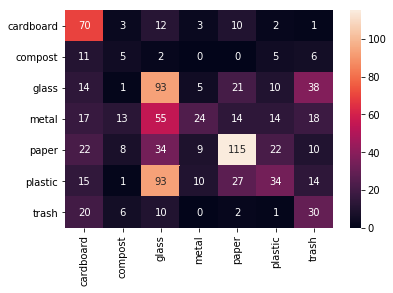

In [20]:
# Visualize the results
import seaborn as sns
cm_viz = sns.heatmap(cm, annot = True, fmt = "d", xticklabels = classes, yticklabels = classes)
cm_viz.figure.savefig("baseline_cm.png")

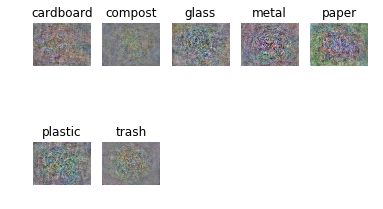

In [15]:
# Visualize the weights
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(384, 512, 3, len(classes))
w_min, w_max = np.min(w), np.max(w)
for i in range(len(classes)):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])